In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
corpus = [
    'assignment for the winter',
    'saidl assignment question',
    'he is a man',
    'she is a woman',
    'delhi is indias capital',
    'berlin is germany capital',
    'paris is france capital',   
]

In [3]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

[['assignment', 'for', 'the', 'winter'], ['saidl', 'assignment', 'question'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['delhi', 'is', 'indias', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]


In [4]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 
save_list(vocabulary, 'vocab.txt')
# print(vocabulary)
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}
# print(word2idx)
print(idx2word)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

{0: 'assignment', 1: 'for', 2: 'the', 3: 'winter', 4: 'saidl', 5: 'question', 6: 'he', 7: 'is', 8: 'a', 9: 'man', 10: 'she', 11: 'woman', 12: 'delhi', 13: 'indias', 14: 'capital', 15: 'berlin', 16: 'germany', 17: 'paris', 18: 'france'}
19


In [5]:
def load_doc(filename):
    file = open(filename, 'r',encoding="ISO-8859-1")
    text = file.read()
    file.close()
    return text

vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

def doc_to_clean_lines(doc, vocab):
    clean_lines = list()
    lines = doc.splitlines()
    for line in lines:
        tokens = line.split()
        table = str.maketrans('', '', punctuation)
        tokens = [w.translate(table) for w in tokens]
        tokens = [w for w in tokens if w in vocab]
        clean_lines.append(tokens)
    return clean_lines

In [6]:
window_size = 2
idx_pairs = []

for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    print(indices)
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) 

[0, 1, 2, 3]
[4, 0, 5]
[6, 7, 8, 9]
[10, 7, 8, 11]
[12, 7, 13, 14]
[15, 7, 16, 14]
[17, 7, 18, 14]


In [7]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [8]:
embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 101
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data[0]
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss at epo 0: 4.8884100914001465
Loss at epo 10: 4.542594909667969
Loss at epo 20: 4.266422748565674
Loss at epo 30: 4.040671348571777
Loss at epo 40: 3.8525638580322266
Loss at epo 50: 3.6930007934570312
Loss at epo 60: 3.555436372756958
Loss at epo 70: 3.435136556625366
Loss at epo 80: 3.328618288040161
Loss at epo 90: 3.233283758163452
Loss at epo 100: 3.1471643447875977


In [9]:
print(log_softmax.shape)
# print(x)
u=W1
v=W2
print(log_softmax)

torch.Size([19])
tensor([-5.7050, -2.7371, -2.6753, -3.9334, -4.8339, -3.2128, -4.0326,
        -1.1836, -2.7583, -6.8611, -4.3177, -6.3072, -2.2289, -2.1878,
        -4.0094, -3.0050, -2.3349, -6.7271, -5.0782])


In [10]:
from sklearn.manifold import TSNE

In [11]:
labels = []
tokens = []
    
for w in vocabulary:
    x = Variable(get_input_layer(word2idx.get(w))).float()
    z1 = torch.matmul(W1, x)
    z2 = torch.matmul(W2, z1)
    log_softmax = F.log_softmax(z2, dim=0)
    labels.append(w)
    tokens.append(log_softmax)
    
tokens = [t.data.numpy() for t in tokens]
print(tokens[0])
print(len(labels))

[ -4.4851413  -1.3303062  -3.9201484  -1.8729156  -2.9576797  -2.586455
  -5.8876357  -6.0467606  -2.829074   -2.399229  -10.467597   -3.010983
  -6.9357834  -4.1642246  -3.7294126  -4.3592567  -6.381886   -2.5168834
  -2.4815707]
19


In [12]:
print("Computing t-SNE embedding")
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne.fit_transform(tokens)

Computing t-SNE embedding


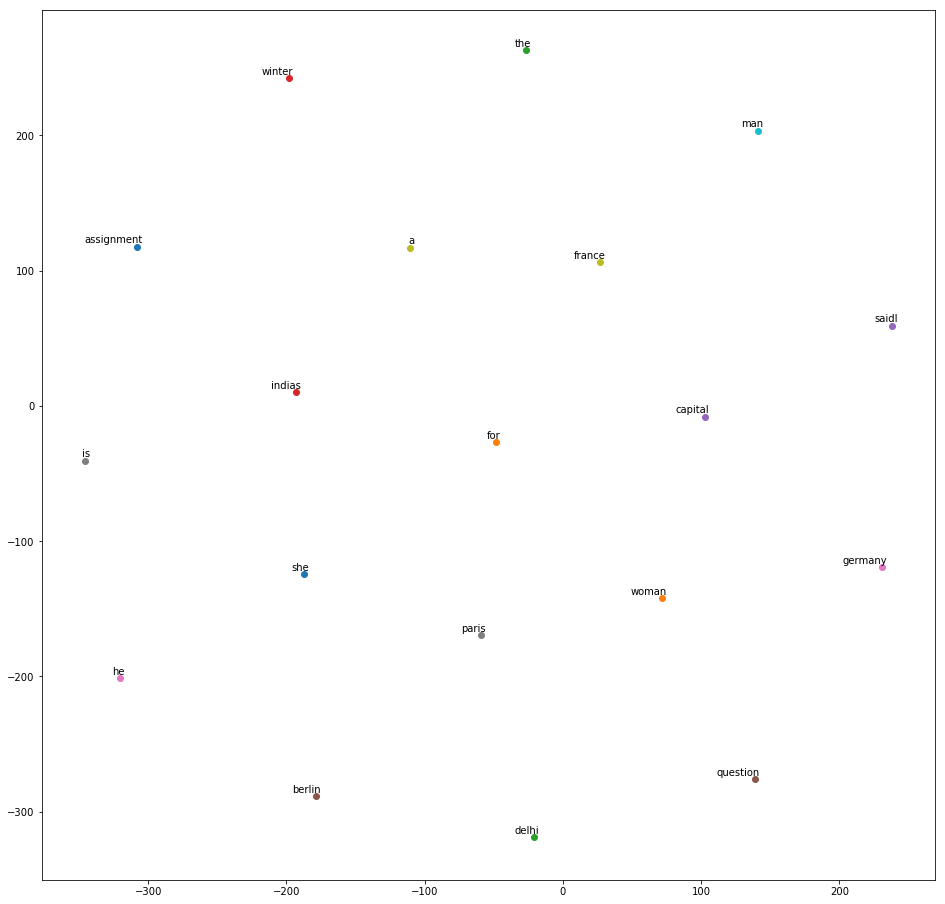

In [13]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
